In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import nltk
import demoji
from sklearn.cluster import KMeans
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import emoji
import string


In [5]:
raw_twcs= pd.read_csv('/Users/parasmalik/Documents/Assignment_eCervx/Data/sample.csv',encoding='utf-8')
data = pd.read_csv('/Users/parasmalik/Documents/Assignment_eCervx/Data/twcs/twcs.csv',encoding='utf-8')

In [6]:
bool_series = pd.notnull(data["tweet_id"])   
data = data[bool_series]
bool_series = pd.notnull(data["author_id"])   
data = data[bool_series]
bool_series = pd.notnull(data["inbound"])   
data = data[bool_series]
bool_series = pd.notnull(data["text"])   
data = data[bool_series]

In [7]:
request = data[pd.isnull(data.in_response_to_tweet_id) & data.inbound]


In [8]:
request_response = pd.merge(request, data, left_on='tweet_id', 
                                  right_on='in_response_to_tweet_id')

In [9]:
response = request_response[request_response.inbound_y ^ True]

In [10]:
features = ['author_id_x','created_at_x','text_x','author_id_y','created_at_y','text_y']
response = response[features]

In [11]:
features = ['author_id_x','created_at_x','text_x','author_id_y','created_at_y','text_y']
response = response[features]

In [12]:
def remove_uppercase(text):
    text_lowercase = ' '.join(x.lower() for x in text.split())# It will discard all uppercases
    return text_lowercase

def remove_emoji(text):
    text = emoji.demojize(text, delimiters=("", ""))
    return text

In [13]:
response['text_x_no_emoji'] = response['text_x'].apply(lambda x: remove_emoji(x))
response['text_x_clean'] = response['text_x_no_emoji'].apply(lambda x: remove_uppercase(x))
response['text_y_no_emoji'] = response['text_y'].apply(lambda x: remove_emoji(x))
response['text_y_clean'] = response['text_y_no_emoji'].apply(lambda x: remove_uppercase(x))
response['author_id_y'] = response['author_id_y'].apply(lambda x: remove_uppercase(x)) 

In [14]:
string.punctuation
def remove_punct(text):
    text_nopunct = "".join([char for char in text if char not in string.punctuation])# It will discard all punctuations
    return text_nopunct
response['text_x_clean'] = response['text_x_clean'].apply(lambda x: remove_punct(x))
response['text_y_clean'] = response['text_y_clean'].apply(lambda x: remove_punct(x))

In [15]:
features = ['author_id_x','created_at_x','text_x_clean','author_id_y','created_at_y','text_y_clean']
response =response[features]
#Now let's shuffle the data
response = response.sample(frac=1)

In [16]:
companies = response['author_id_y'].unique()
response['text_x_clean'] = response['text_x_clean'].str.replace('\d+', '')
response['text_y_clean'] = response['text_y_clean'].str.replace('\d+', '')

In [17]:
response['text_x_clean'] = response['text_x_clean'].str.replace('|'.join(companies), '')
response['text_y_clean'] = response['text_y_clean'].str.replace('|'.join(companies), '')

In [18]:
#Removing most common words

freqX = pd.Series(' '.join(response['text_x_clean']).split()).value_counts()[:10]
freqY = pd.Series(' '.join(response['text_y_clean']).split()).value_counts()[:10]
print('FREQ X: \n',freqX,'\nFREQ Y: \n', freqY)

FREQ X: 
 to     450771
i      419677
the    394086
my     310607
a      289705
and    250549
is     210780
for    199934
on     184365
you    172960
dtype: int64 
FREQ Y: 
 to      597010
you     562841
the     438571
your    355927
we      300935
us      281678
for     280735
can     262541
a       257072
this    245768
dtype: int64


In [19]:
#removing them
freqX = list(freqX.index)
freqY = list(freqY.index)
response['text_x_clean'] = response['text_x_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in freqX))
response['text_y_clean'] = response['text_y_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in freqY))

In [20]:
#Removing most rare words
rareX = pd.Series(' '.join(response['text_x_clean']).split()).value_counts()[-100:]
rareY = pd.Series(' '.join(response['text_y_clean']).split()).value_counts()[-100:]
print('RARE X: \n',rareX,'\nRARE Y: \n', rareY)

RARE X: 
 whatisthereasontoblock      1
httpstcouwfytaxbar          1
httpstcoskisahwo            1
httpstcowcnfqydjv           1
narcissists                 1
                           ..
newphonefeels               1
httpstcovecezhnp            1
onfacewithsymbolsonmouth    1
httpstcopoyiajis            1
httpstcooiwhbiex            1
Length: 100, dtype: int64 
RARE Y: 
 httpstcofpigeiew         1
httpstcoyvujxlrsd        1
veio                     1
shanika                  1
requestdn                1
                        ..
httpstcoaivtjfuha        1
linkhttpstcoimuysethr    1
httpstcooymtacg          1
shamber                  1
angemeldet               1
Length: 100, dtype: int64


In [21]:
rareX = list(rareX.index)
rareY = list(rareY.index)
response['text_x_clean'] = response['text_x_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in rareX))
response['text_y_clean'] = response['text_y_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in rareY))

In [22]:
train_response = response.iloc[0:700000,:]
val_response = response.iloc[700000:740000, :]
test_response = response.iloc[740000:, :]

In [23]:
train_sentences=[]
valid_sentences = []
test_sentences =[]
for i in range(0,len(train_response)):
  train_sentences.append(str(train_response['text_x_clean'].iloc[i]))

for i in range(0,len(val_response)):
  valid_sentences.append(str(val_response['text_x_clean'].iloc[i]))

for i in range(0,len(test_response)):
  test_sentences.append(str(test_response['text_x_clean'].iloc[i]))

In [24]:
#Tuning hyperparameters
# to use our own dictionary
vocab_size = 50000
max_length = 50
trunc_type = 'post'
pad_type = 'post'
oov_tok = "<OOV>"

In [25]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts (train_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(train_sentences)
padded = pad_sequences(sequences, maxlen = max_length, padding=pad_type , truncating= trunc_type)
valid_sequences = tokenizer.texts_to_sequences(valid_sentences)
valid_padded = pad_sequences(valid_sequences, maxlen = max_length, padding=pad_type , truncating= trunc_type)
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen = max_length, padding=pad_type , truncating= trunc_type)
print(len(test_padded))
print(len(valid_padded))
print(len(padded))

54299
40000
700000


In [32]:
#After experimenting with various cluster dimension came to conclusion that 3 cluster's are enough for the analysis
kmeans = KMeans(n_clusters=3, random_state=0).fit(padded)
print(kmeans.cluster_centers_)

[[2.22444359e+03 3.01140985e+03 4.17514873e+03 1.58239984e+03
  5.26930851e+03 5.51859647e+03 5.52830270e+03 5.02581190e+03
  4.79735695e+03 4.50391853e+03 4.15932955e+03 3.84518565e+03
  3.35684256e+03 2.98908348e+03 2.59451639e+03 2.24985321e+03
  1.84891301e+03 1.57297370e+03 1.25200601e+03 1.01946528e+03
  8.44390070e+02 6.59975520e+02 5.81105605e+02 4.73485271e+02
  4.17995681e+02 3.75884704e+02 3.39651162e+02 3.16237511e+02
  2.72306906e+02 2.49461405e+02 2.32945679e+02 2.07244264e+02
  1.77674951e+02 1.66705143e+02 1.43321409e+02 1.35134471e+02
  1.07727222e+02 9.41725775e+01 7.22539110e+01 5.53810364e+01
  4.90661719e+01 3.46742712e+01 3.03091200e+01 2.34083230e+01
  1.82541193e+01 1.33414824e+01 1.01035991e+01 5.09920300e+00
  5.48619227e+00 4.20035739e+00]
 [1.81961044e+03 2.34169919e+03 2.77391914e+03 2.51375329e+04
  2.86529713e+03 2.47554357e+03 2.25986506e+03 2.11937240e+03
  1.93739060e+03 1.82948137e+03 1.76919634e+03 1.58658147e+03
  1.57547906e+03 1.46384467e+03 1.353

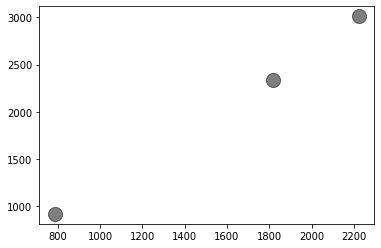

In [33]:
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [34]:
from collections import Counter, defaultdict
print(Counter(kmeans.labels_))

Counter({2: 591424, 0: 91222, 1: 17354})


In [35]:
padded[kmeans.labels_==0,:]

array([[ 1771,    18,   188, ...,     0,     0,     0],
       [ 1486, 17590,  3888, ...,     0,     0,     0],
       [  665,   878,  5069, ...,     0,     0,     0],
       ...,
       [  102, 16773, 11160, ...,     0,     0,     0],
       [  424,   945,    85, ...,     0,     0,     0],
       [ 4557,   744,   176, ...,     0,     0,     0]], dtype=int32)

In [36]:
#Checking for validation dataset 
prediction = kmeans.predict(valid_padded)

In [38]:
for i in range(0,len(prediction)):
    print("preditiing cluster")
    print(prediction[i])

predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
1
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
1
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2


predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
1
predition cluster
0
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
1
predition cluster
1
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2


predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2


2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
1
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster


2
predition cluster
0
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
1
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
1
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster


predition cluster
1
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
1
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2


predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
1
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2


2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
1
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
1
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
0
predition cluster
0
predition cluster


2
predition cluster
2
predition cluster
2
predition cluster
1
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
1
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster


predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
1
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2


predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
1
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2


2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
1
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
1
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster


0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster


predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
1
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2


predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
1
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2


2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
1
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster


0
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster


predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
1
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
1
predition cluster
2
predition cluster
0


predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
1
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
1
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2


2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
1
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
1
predition cluster
1
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
0
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster


0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
1
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster


predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
1
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2


predition cluster
2
predition cluster
0
predition cluster
0
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
1
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2


2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
1
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster


2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster


predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2


2
predition cluster
2
predition cluster
2
predition cluster
1
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster


2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
1
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster


2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
1
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster


2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster


predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
1
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2


2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
1
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
1
predition cluster
2
predition cluster


predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
1
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2


predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
1
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
1
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2


predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
1
predition cluster
1
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
1
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
0
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2


2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
0
predition cluster
2
predition cluster
0
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster


2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
0
predition cluster
2
predition cluster


predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
0
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
1
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2


predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2


2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
1
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster


2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster


predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
1
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2


2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
0
predition cluster
0
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
2
predition cluster
1
predition cluster
2
predition cluster
